# 1. Import

In [204]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from cdlib import viz
import os
import sys
import warnings
warnings.filterwarnings('ignore')
import networkx as nx
#from pyvis import network as net
from cdlib import algorithms, viz, TemporalClustering, evaluation
from difflib import get_close_matches
from collections import Counter
from difflib import SequenceMatcher
#import pandas_profiling
#from nltk.corpus import names
import json
from faker import Faker
import pycountry
import plotly.graph_objects as go
import plotly.express as px
import bokeh as bk

## 1.1 Importing data

In [104]:
# load data from tsv file to a pandas dataframe
movies_metadata = pd.read_csv(
    'MovieSummaries/movie.metadata.tsv', sep='\t', header=None)
character_metadata = pd.read_csv(
    'MovieSummaries/character.metadata.tsv', sep='\t', header=None)
plot_summaries = pd.read_csv(
    'MovieSummaries/plot_summaries.txt', sep='\t', header=None)



The columns have the following labels (extracted from Pandaprofiling reports and our analysis):

Movie metadata:

| Column | Type of data  | Missing values    | Summary   |
|---:|:-------------|:-----------|:------|
| Wikipedia movie ID | Integer unique  | 0       | Unique Wikipedia IDs to identify movies  |
| Freebase movie ID | Categorical unique  | 0    | Unique identifiers for movies in the Freebase database.  |
| Movie name | Categorical  | 0       | Movie name in original language   | 
| Movie release date | Categorical  | 6902 / 8.4%    | Date of release of the movie , can be in different formats and contains some missing values   |
| Movie box office revenue | Real number  | 73340 / 89.7%       | Income from ticket sales of the movie . Too many missing values , this column cannot be used . It is also not ideal to replace these values from other data sources since a large portion of the movies of our dataset don't figure in the box office at all . A good idea would be to replace this column with another score metric ( like IMDB ratings ) if needed in P3   |
| Movie runtime | Real number  | 20450 / 25.0%    | Length of the movie in minutes . Important amount of missing values but this column won't be needed in our analysis   |
| Movie languages | Categorical  | 13866 / 17.0%       | Original language of the movie . Represented in dictionary format with each language and its associated Freebase ID . Contains A few missing values .  |
| Movie countries | Categorical  | 8154 / 10.0%    | Country where the movie was released . Represented in dictionary format with each country and its associated Freebase ID . Some missing values but we don't use this column yet . An interesting idea for the next milestone would be to compare communities country distribution with the movie country   |
| Movie genres | Categorical | 2294 / 2.8%      | Genre of the movie . Represented in dictionary format with each genre and its associated Freebase ID . Few missing values but we don't use this column yet . This label can be useful to test hypothesis involving communities  |

Character metadata:

| Column | Type of data  | Missing values    | Summary   |
|---:|:-------------|:-----------|:------|
| Wikipedia movie ID | Integer   | 0       | Wikipedia ID of the movie where a character is portrayed  |
| Freebase movie ID | Categorical unique  | 0    | Identifiers for movies in the Freebase database a character is portrayed  |
| Movie release date | Categorical  | 9995 / 2.2%    | Date of release of the movie , can be in different formats and contains some missing values   |
| Character name | Categorical  | 257875 / 57.2%       | Name of character portrayed . Contains a lot of missing values and won't be used in our analysis  |
| Actor date of birth | Categorical  | 106145 / 23.6%    | Date of birth of the concerned actor . Significant amount of missing values which we will be filling later after communties are established ( explained below ). The actor date of birth is converted to actor age  |
| Actor gender | Categorical  | 45609 / 10.1%       | Gender of the actor , either "M" or "F" . Missing values are replaced using queries from Wikidata  |
| Actor height | Real number  | 295845 / 65.6%    | Height of the actor in meters . A lot of missing and skewed values but we won't use this column in our analysis. |
| Actor ethnicity  | Categorical | 344611 / 76.5%      | Freebase ID of the ethnicity of the actor . Very interesting feature that would have contributed a lot in our analysis but too many missing values and no way of replacing them . Will be replaced with country of citizenship of the actor after querying from Wikidata   |
| Actor name | Categorical  | 1228 / 0.3%    | Name of the actor . Contains some duplicates since some actors have the same name , therefore can't be used reliably to identify specific actors  |
| Actor age at movie release | Real number  | 158113 / 35.1%       | Age of the actor when the movie was released . Contains a lot of missing and skewed values but we won't use this column in our analysis |
| Freebase character/actor map ID | Categorical  | 0    | Unique Freebase ID of the character. We won't use this column in our analysis  |
| Freebase character ID | Categorical | 257865 / 57.2%      | Unique Freebase ID of the character. Contains a lot of missing data and we won't use this column in our analysis   |
| Freebase actor ID | Categorical | 815 / 0.2%      | Very few missing values that will be dropped . Main identifier for actors in our analysis  |

In [105]:
# label the columns
movies_metadata.columns = ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_name', 'Movie_release_date',
                           'Movie_box_office_revenue', 'Movie_runtime', 'Movie_languages', 'Movie_countries', 'Movie_genres']
character_metadata.columns = ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_release_date', 'Character_name', 'Actor_date_of_birth', 'actor_gender',
                              'Actor_height_(in_meters)', 'Actor_ethnicity', 'Actor_name', 'Actor_age_at_movie_release', 'Freebase_character/actor_map_ID', 'Freebase_character_ID', 'Freebase_actor_ID']
plot_summaries.columns = ['Wikipedia_movie_ID', 'Plot_summary']


## 1.2 Visualizing samples of raw data

In [106]:
movies_metadata.sample(3)


,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
18239,8324446,/m/05pdggb,The Golem and the Dancing Girl,1917-01-15,NaN,NaN,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/05p553"": ""Comedy film"", ""/m/03npn"": ""Horr..."
22691,3124974,/m/08t14_,Gambit,1966,NaN,109.0,"{""/m/064_8sq"": ""French Language"", ""/m/0jzc"": ""...","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th..."
26549,5506192,/m/0dpybs,Swaham,1994,NaN,141.0,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}","{""/m/07s9rl0"": ""Drama"", ""/m/02n4lw"": ""Art film""}"


In [107]:
character_metadata.sample(3)


,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,actor_gender,Actor_height_(in_meters),Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character/actor_map_ID,Freebase_character_ID,Freebase_actor_ID
206857,24794675,/m/080k7f6,2008,NaN,NaN,F,NaN,NaN,Mariana Elizondo,NaN,/m/0gcl8gx,NaN,/m/0gc944l
59552,560449,/m/02q2br,1941,Ma,1887-04-26,F,NaN,NaN,Elisabeth Risdon,NaN,/m/0c0lwg0,/m/0c0lwg3,/m/02x6kqd
169204,24014305,/m/07kcjdh,1992-05-11,Mother,1954-06-18,F,NaN,NaN,Tinna Gunnlaugsdóttir,37.0,/m/0bx2tvm,/m/0n5qx6y,/m/07k5p0k


In [108]:
plot_summaries.sample(3)


,Wikipedia_movie_ID,Plot_summary
12290,409754,"In the movie, Lan Yu , played by Liu Ye, a poo..."
41835,7561586,When 17-year-old Jane Broadbent comes to Londo...
40325,19801670,"Lizabeth Scott plays Elsa Jenner, widowed moth..."


# 2. Understanding and cleaning data

## 2.1 Exploring raw data

We use the pandas_profiling librarie to get a first rapid overview of the data. It gives many information like value repartition, correlations and missing values.
<br>It ouptput the `character_metadata_report.html` and `movies_metadata_report.html` which can be found in the repo in the folder "Profiling_reports" and doesn't requierd to re-run every time so we comment it.

In [109]:
# # profile the movies metadata dataframe using pandas profiling library than save the report to a html file
# movies_metadata.profile_report(title='Movies Metadata Report').to_file(output_file="Profiling_reports/movies_metadata_report.html")


In [110]:
# # profile the character metadata dataframe using pandas profiling library than save the report to a html file
# character_metadata.profile_report(title='Character Metadata Report').to_file(output_file="Profiling_reports/character_metadata_report.html")


We remark that for movies the `Movie_box_office_revenue`, `Movie_runtime` columns have some missing values and we face the same problems with those columns `Character_name`, `Actor_date_of_birth`, `Actor_height_(in_meters)`, `Actor_ethnicity` in the actor dataset. We'll probably not use most of them except for the boxoffice revenue and the ethnicity who could be interresting but will need some scarping to add missing values.

## 2.2 Cleaning the data

### 2.2.1 Feature selection

For the subsequent analysis we will drop the columns representing features we won't use. namely:
- `Movie_box_office_revenue`, `Movie_runtime` in the movies_metadata dataset
- `Character_name`, `Actor_height_(in_meters)`, `Actor_ethnicity`, `Actor_age_at_movie_release`, `Freebase_character/actor_map_ID`, `Freebase_character_ID` in the character_metadata dataset.

In [111]:
# drop the columns that are not needed from the movies metadata dataframe:
movies_metadata.drop(['Movie_box_office_revenue', 'Movie_runtime'], axis=1, inplace=True)
# drop the columns that are not needed from the character metadata dataframe:
character_metadata.drop(['Character_name', 'Actor_height_(in_meters)', 'Actor_ethnicity', 'Actor_age_at_movie_release',
                        'Freebase_character/actor_map_ID', 'Freebase_character_ID'], axis=1, inplace=True)


### 2.2.2 movies_metadata dataset: feature pre-processing

In [112]:
movies_metadata


,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_languages,Movie_countries,Movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ..."


#### 2.2.1.1  `Movie_release_date` column

In [113]:
# show the unique string lengths of the release date column with their counts
movies_metadata['Movie_release_date'].str.len().value_counts()


10.0    39373
4.0     32172
7.0      3294
Name: Movie_release_date, dtype: int64

In [114]:
# show exemples of dates with length 4,7 and 10 respectively
print(movies_metadata[movies_metadata['Movie_release_date'].str.len(
) == 4].sample(1)['Movie_release_date'].values[0])
print(movies_metadata[movies_metadata['Movie_release_date'].str.len(
) == 7].sample(1)['Movie_release_date'].values[0])
print(movies_metadata[movies_metadata['Movie_release_date'].str.len(
) == 10].sample(1)['Movie_release_date'].values[0])


1952
1988-05
2001-06-16


In [115]:
# show the number of missing values in the movie release date column
movies_metadata['Movie_release_date'].isnull().sum()


6902

**Dropped**: We first convert the `Movie_release_date` column to a datetime object and then we extract the year of release, we will rename the column `Movie_release_year` to avoid confusion.


**validated**: We strip the year from the `Movie_release_date` column as the substring before the first - character.


In [116]:
# get the year from the release date column
movies_metadata['Movie_release_year'] = movies_metadata['Movie_release_date'].str.split(
    '-').str[0]
# drop the release date column
movies_metadata.drop(['Movie_release_date'], axis=1, inplace=True)

#### 2.2.1.2 `Movie_genres` column

In [117]:
# function that coverts the string to a dictionary
def convert_to_dict(string):
    if isinstance(string, str):
        if string == '{}':
            return {}
        else:
            string = string.replace('{', '').replace('}', '').replace('"', '')
            string = string.split(',')
            string = [x.split(':') for x in string]
            dictionnary = {x[0].strip(): x[1].strip() for x in string}
            return dictionnary

In [118]:
# apply the function to the genres column
movies_metadata['Movie_genres'] = movies_metadata['Movie_genres'].apply(
    convert_to_dict)


In [119]:
# show the number of missing values in the genres column (empty dictionaries)
movies_metadata[movies_metadata['Movie_genres'] == {}].shape[0]


2294

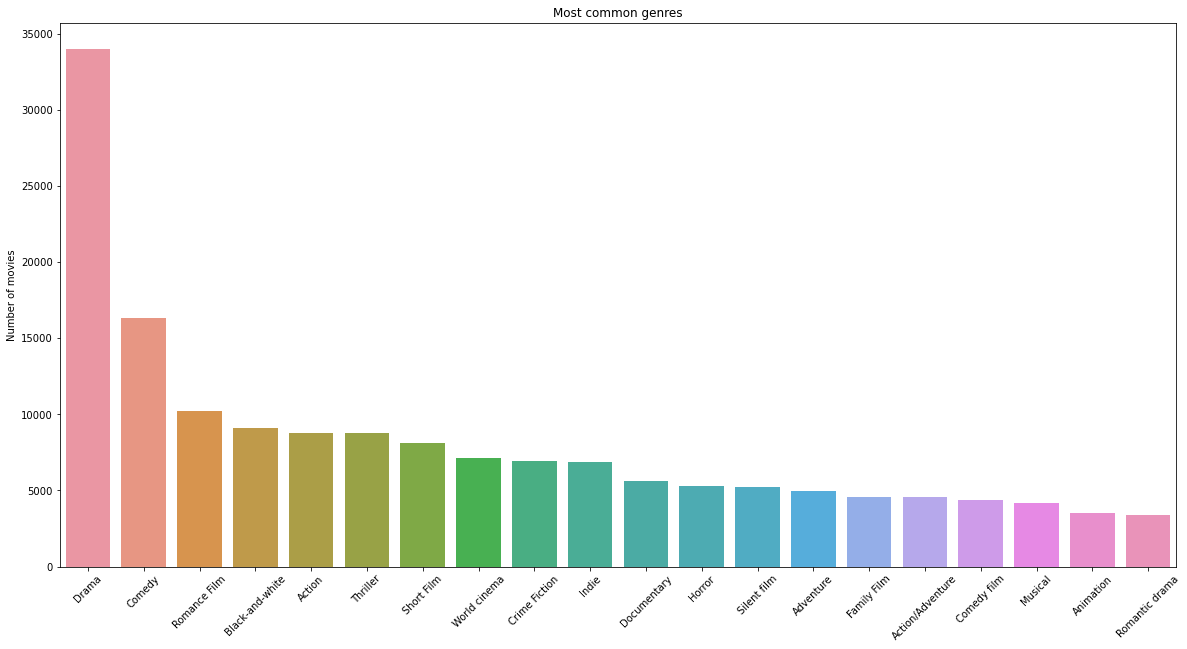

In [120]:
# visualize the most common genres
plt.figure(figsize=(20, 10))
plt.title('Most common genres')
plt.ylabel('Number of movies')
sns.barplot(x=[x for x, y in Counter([x for y in movies_metadata['Movie_genres'].values for x in y.values()]).most_common(
    20)], y=[y for x, y in Counter([x for y in movies_metadata['Movie_genres'].values for x in y.values()]).most_common(20)])
plt.xticks(rotation=45)
plt.show()


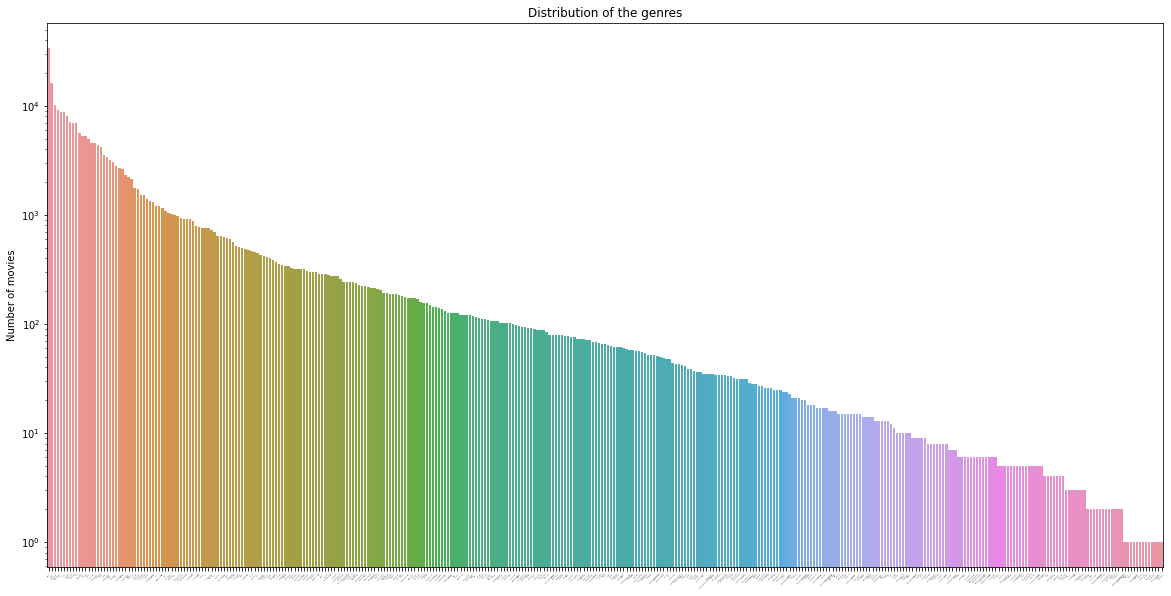

List of genres
['Drama', 'Comedy', 'Romance Film', 'Black-and-white', 'Action', 'Thriller', 'Short Film', 'World cinema', 'Crime Fiction', 'Indie', 'Documentary', 'Horror', 'Silent film', 'Adventure', 'Family Film', 'Action/Adventure', 'Comedy film', 'Musical', 'Animation', 'Romantic drama', 'Mystery', 'Science Fiction', 'Fantasy', 'Romantic comedy', 'War film', 'Japanese Movies', 'Western', 'Crime Thriller', 'Period piece', 'Comedy-drama', 'Film adaptation', 'Chinese Movies', 'Biography', 'Psychological thriller', 'Bollywood', 'Sports', 'Biographical film', 'LGBT', 'Music', 'Family Drama', 'Black comedy', 'Parody', 'Television movie', 'Martial Arts Film', "Children's/Family", 'Teen', 'Coming of age', 'History', 'Political drama', 'Slasher', 'Suspense', 'Cult', 'Culture & Society', 'Melodrama', 'Satire', 'Supernatural', 'Biopic [feature]', 'Film noir', 'Slapstick', 'Historical fiction', 'Crime Drama', 'Action Thrillers', "Children's", 'B-movie', 'Costume drama', 'Spy', 'Art film', 'Ens

In [121]:
# visualize the distribution of the genres in log scale
plt.figure(figsize=(20, 10))
plt.title('Distribution of the genres')
plt.ylabel('Number of movies')
plt.yscale('log')
sns.barplot(x=[x for x, y in Counter([x for y in movies_metadata['Movie_genres'].values for x in y.values()]).most_common()], y=[
            y for x, y in Counter([x for y in movies_metadata['Movie_genres'].values for x in y.values()]).most_common()])
plt.xticks(rotation=45, fontsize=1)
plt.show()

print('List of genres')
print([x for x, y in Counter([x for y in movies_metadata['Movie_genres'].values for x in y.values()]).most_common()])

We can easily notice that the genres distribution follows a power law.

#### 2.2.1.3 `Movie_countries` column

In [122]:
# apply the same function as Movies_genre to the countries column
movies_metadata['Movie_countries'] = movies_metadata['Movie_countries'].apply(
    convert_to_dict)
# show the number of missing values in the countries column (empty dictionaries)
movies_metadata[movies_metadata['Movie_countries'] == {}].shape[0]

8154

In [123]:
movies_metadata

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_languages,Movie_countries,Movie_genres,Movie_release_year
0,975900,/m/03vyhn,Ghosts of Mars,"{""/m/02h40lc"": ""English Language""}",{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",2001
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,"{""/m/02h40lc"": ""English Language""}",{'/m/09c7w0': 'United States of America'},"{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp...",2000
2,28463795,/m/0crgdbh,Brun bitter,"{""/m/05f_3"": ""Norwegian Language""}",{'/m/05b4w': 'Norway'},"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...",1988
3,9363483,/m/0285_cd,White Of The Eye,"{""/m/02h40lc"": ""English Language""}",{'/m/07ssc': 'United Kingdom'},"{'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic...",1987
4,261236,/m/01mrr1,A Woman in Flames,"{""/m/04306rv"": ""German Language""}",{'/m/0345h': 'Germany'},{'/m/07s9rl0': 'Drama'},1983
...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,"{""/m/02h40lc"": ""English Language""}",{'/m/09c7w0': 'United States of America'},{'/m/07s9rl0': 'Drama'},2011
81737,34980460,/m/0g4pl34,Knuckle,"{""/m/02h40lc"": ""English Language""}","{'/m/03rt9': 'Ireland', '/m/07ssc': 'United Ki...","{'/m/03bxz7': 'Biographical film', '/m/07s9rl0...",2011
81738,9971909,/m/02pygw1,Another Nice Mess,"{""/m/02h40lc"": ""English Language""}",{'/m/09c7w0': 'United States of America'},"{'/m/06nbt': 'Satire', '/m/01z4y': 'Comedy'}",1972
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,"{""/m/03_9r"": ""Japanese Language""}",{'/m/03_3d': 'Japan'},"{'/m/06n90': 'Science Fiction', '/m/0gw5n2f': ...",1992


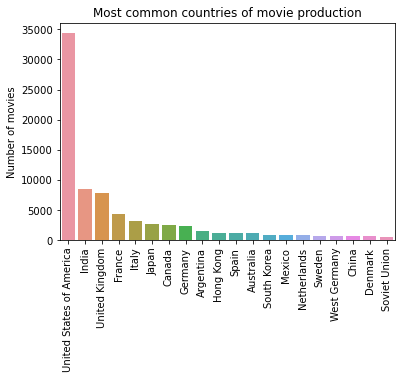

List of countries of movie production
['United States of America', 'India', 'United Kingdom', 'France', 'Italy', 'Japan', 'Canada', 'Germany', 'Argentina', 'Hong Kong', 'Spain', 'Australia', 'South Korea', 'Mexico', 'Netherlands', 'Sweden', 'West Germany', 'China', 'Denmark', 'Soviet Union', 'Philippines', 'Poland', 'Czechoslovakia', 'Belgium', 'New Zealand', 'Norway', 'Russia', 'Hungary', 'German Democratic Republic', 'Yugoslavia', 'Brazil', 'Ireland', 'Switzerland', 'Austria', 'Finland', 'Czech Republic', 'Israel', 'Turkey', 'England', 'Iran', 'Thailand', 'South Africa', 'Greece', 'Pakistan', 'Taiwan', 'Portugal', 'Croatia', 'Egypt', 'Romania', 'Indonesia', 'Malaysia', 'Bulgaria', 'Sri Lanka', 'Singapore', 'Iceland', 'Cambodia', 'Luxembourg', 'Bangladesh', 'Weimar Republic', 'Chile', 'Serbia', 'Morocco', 'Colombia', 'Cuba', 'Scotland', 'Algeria', 'Nepal', 'Tunisia', 'Lebanon', 'Bosnia and Herzegovina', 'Estonia', 'Burkina Faso', 'Slovakia', 'Senegal', 'Slovenia', 'Puerto Rico', 'Vene

In [124]:
# visualize the most common countries
#plt.figure(figsize=(10, 10))
plt.title('Most common countries of movie production')
plt.ylabel('Number of movies')
sns.barplot(x=[x for x, y in Counter([x for y in movies_metadata['Movie_countries'].values for x in y.values()]).most_common(
    20)], y=[y for x, y in Counter([x for y in movies_metadata['Movie_countries'].values for x in y.values()]).most_common(20)])
plt.xticks(rotation=90)
plt.show()

print('List of countries of movie production')
print([x for x, y in Counter([x for y in movies_metadata['Movie_countries'].values for x in y.values()]).most_common()])


#### 2.2.1.4 `Movie_languages` column

In [125]:
movies_metadata['Movie_languages'].iloc[1825]

'{"/m/0gtg": "\\ud801\\udc16\\ud801\\udc32\\ud801\\udc49\\ud801\\udc4b\\ud801\\udc4c\\ud801\\udc32", "/m/04306rv": "German Language"}'

In [126]:
# function that converts the string to a list
def clean_language(elt):
    if ':' in elt:
        elt = elt[elt.index(':') + 1 : ]
    elt = elt.strip()
    return elt

def convert_to_list(string):
    if isinstance(string, str):
        if string == '{}':
            return []
        else:
            string = string.replace('{', '').replace('}', '').replace('"', '')
            string = string.split(',')
            string = [clean_language(x) for x in string]
            return string

In [127]:
# apply the function to the language column
movies_metadata['Movie_languages'] = movies_metadata['Movie_languages'].apply(convert_to_list)

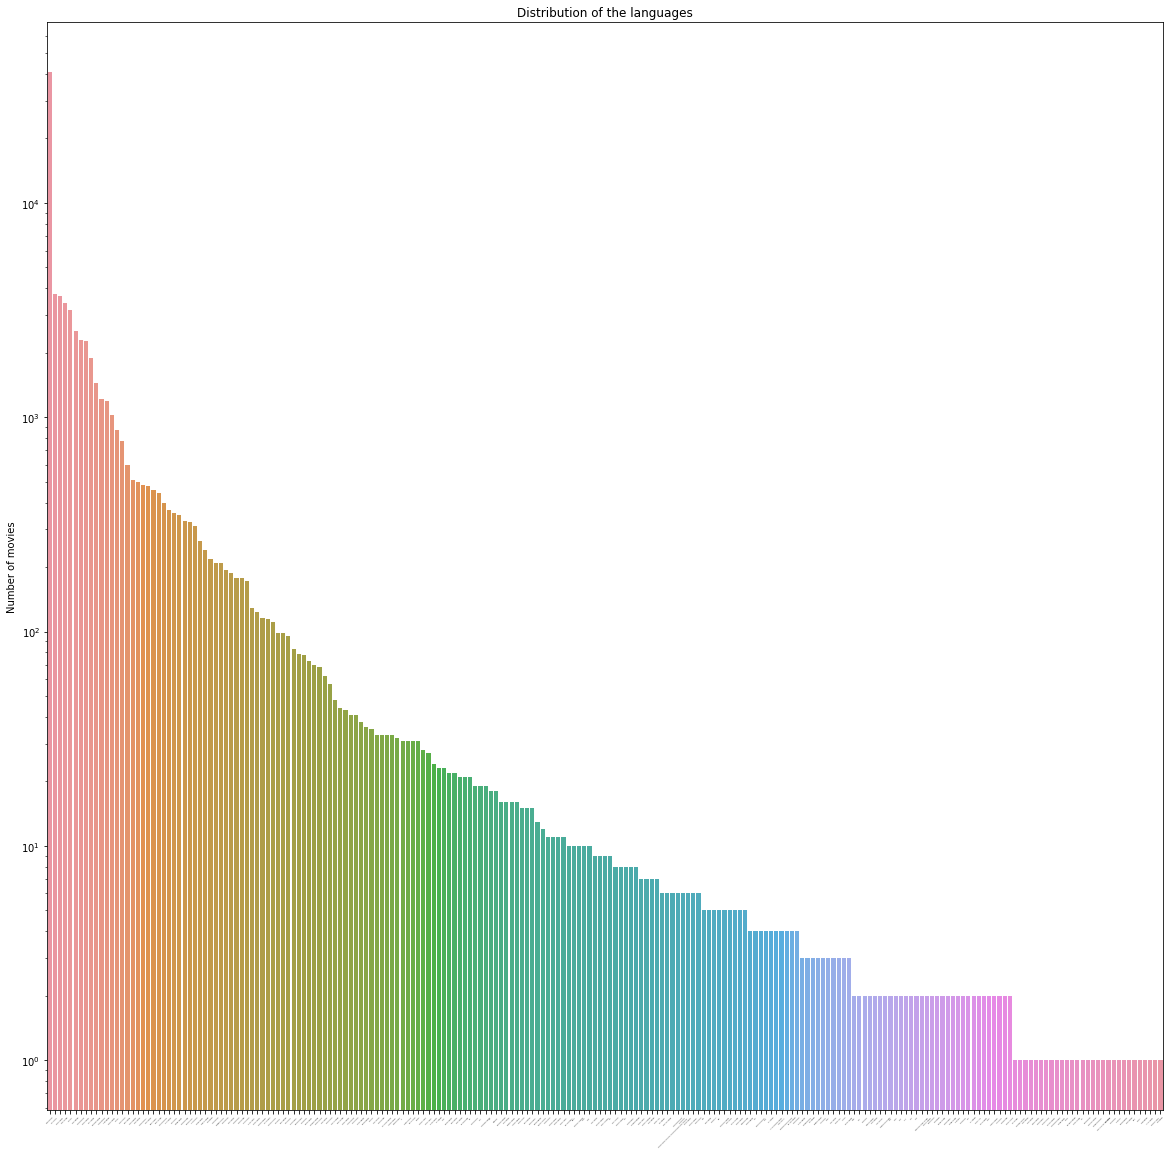

List of languages
['English Language', 'Hindi Language', 'Spanish Language', 'French Language', 'Silent film', 'Italian Language', 'Japanese Language', 'German Language', 'Tamil Language', 'Malayalam Language', 'Standard Mandarin', 'Telugu language', 'Russian Language', 'Cantonese', 'Korean Language', 'Dutch Language', 'Swedish Language', 'Arabic Language', 'Standard Cantonese', 'Czech Language', 'Bengali Language', 'Danish Language', 'Portuguese Language', 'Polish Language', 'Urdu Language', 'Tagalog language', 'Kannada Language', 'Mandarin Chinese', 'Serbian language', 'Hebrew Language', 'Hungarian language', 'Thai Language', 'Persian Language', 'Norwegian Language', 'Turkish Language', 'Greek Language', 'Punjabi language', 'Filipino language', 'Finnish Language', 'Chinese language', 'Croatian language', 'Romanian Language', 'American English', 'Indonesian Language', 'Serbo-Croatian', 'Malay Language', 'Latin Language', 'Sinhala Language', 'Bulgarian Language', 'Oriya Language', 'Mar

In [128]:
# show the number of missing values in the language column
#movies_metadata[movies_metadata['Movie_languages_test'] == [[]]]
plt.figure(figsize=(20,20))
plt.title('Distribution of the languages')
plt.ylabel('Number of movies')
plt.yscale('log')
sns.barplot(x=[x for x, y in Counter([x for y in movies_metadata['Movie_languages'].values for x in y]).most_common()], y=[
            y for x, y in Counter([x for y in movies_metadata['Movie_languages'].values for x in y]).most_common()])
plt.xticks(rotation=45, fontsize=1)
plt.show()

print('List of languages')
print([x for x, y in Counter([x for y in movies_metadata['Movie_languages'].values for x in y]).most_common()])


In [129]:
# Storing the cleaned dataset for further use
movies_metadata.to_csv('./CSV_files/all_movies_metadata.csv')
movies_metadata

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_languages,Movie_countries,Movie_genres,Movie_release_year
0,975900,/m/03vyhn,Ghosts of Mars,[English Language],{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",2001
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,[English Language],{'/m/09c7w0': 'United States of America'},"{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp...",2000
2,28463795,/m/0crgdbh,Brun bitter,[Norwegian Language],{'/m/05b4w': 'Norway'},"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...",1988
3,9363483,/m/0285_cd,White Of The Eye,[English Language],{'/m/07ssc': 'United Kingdom'},"{'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic...",1987
4,261236,/m/01mrr1,A Woman in Flames,[German Language],{'/m/0345h': 'Germany'},{'/m/07s9rl0': 'Drama'},1983
...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,[English Language],{'/m/09c7w0': 'United States of America'},{'/m/07s9rl0': 'Drama'},2011
81737,34980460,/m/0g4pl34,Knuckle,[English Language],"{'/m/03rt9': 'Ireland', '/m/07ssc': 'United Ki...","{'/m/03bxz7': 'Biographical film', '/m/07s9rl0...",2011
81738,9971909,/m/02pygw1,Another Nice Mess,[English Language],{'/m/09c7w0': 'United States of America'},"{'/m/06nbt': 'Satire', '/m/01z4y': 'Comedy'}",1972
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,[Japanese Language],{'/m/03_3d': 'Japan'},"{'/m/06n90': 'Science Fiction', '/m/0gw5n2f': ...",1992


### 2.2.3 **character_metadata** dataset: feature pre-processing

#### 2.2.3.1 `Movie_release_date` column

In [130]:
# As we did with the movies metadata dataframe, we will get the year from the release date column
character_metadata['Movie_release_year'] = character_metadata['Movie_release_date'].str.split(
    '-').str[0]
# drop the release date column
character_metadata.drop(['Movie_release_date'], axis=1, inplace=True)

# show the number of missing values in the movie release year column
print('Number of missing values in the movie release year column: {}'.format(
    character_metadata['Movie_release_year'].isnull().sum()))
# fill the missing values in the movie release year column with the median
character_metadata['Movie_release_year'].fillna(
    character_metadata['Movie_release_year'].median(), inplace=True)


Number of missing values in the movie release year column: 9995


In [131]:
# show the unique values of the movie release year column
years = character_metadata['Movie_release_year'].unique().astype(int)
years.sort()
print('Unique values: {}'.format(years))
# replace '1010' with '2010'
character_metadata['Movie_release_year'] = character_metadata['Movie_release_year'].replace(
    '1010', '2010')
# find the interval of the movie release year column
print('Min: {}'.format(years.min()))
print('Max: {}'.format(years.max()))


Unique values: [1010 1888 1891 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903
 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917
 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931
 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945
 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959
 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1994 1995 1996 1997 1998 1999 2000
 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014
 2015 2016]
Min: 1010
Max: 2016


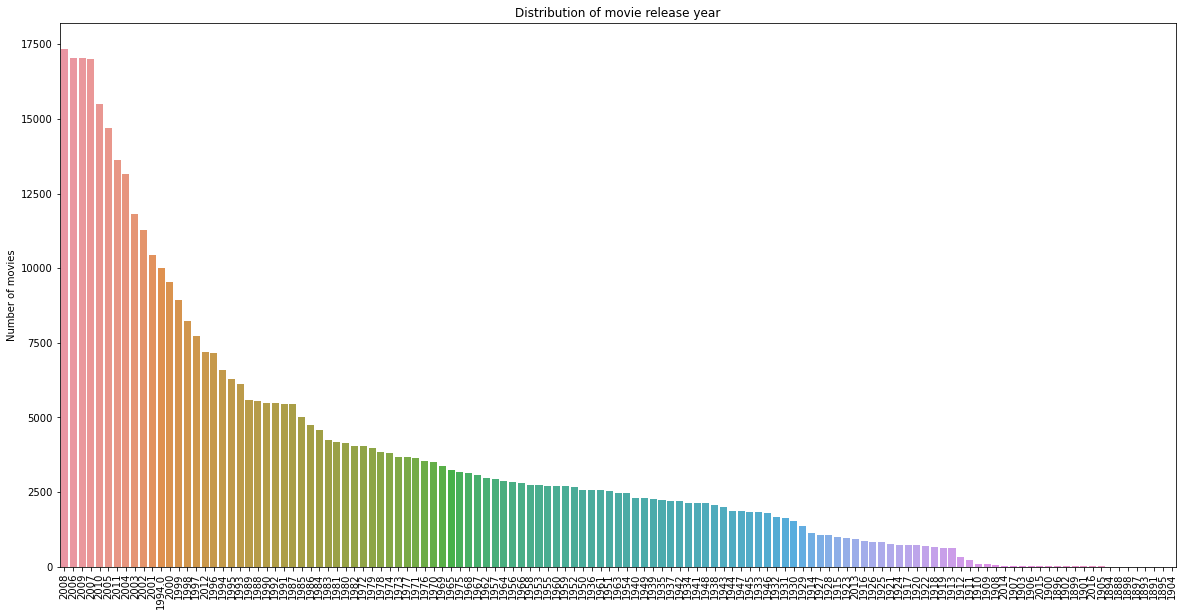

In [132]:
# visulaise the distribution of movie release year column
plt.figure(figsize=(20, 10))
plt.title('Distribution of movie release year')
plt.ylabel('Number of movies')
sns.barplot(x=character_metadata['Movie_release_year'].value_counts(
).index, y=character_metadata['Movie_release_year'].value_counts().values)
ax = plt.xticks(rotation=90, fontsize=10)


#### 2.2.3.2 `Actor_date_of_birth` column

In [133]:
# As we did with the previous column, we will get the year from the actor date of birth column
character_metadata['Actor_year_of_birth'] = character_metadata['Actor_date_of_birth'].str.split(
    '-').str[0]
# drop the actor date of birth column
character_metadata.drop(['Actor_date_of_birth'], axis=1, inplace=True)
# show the number of missing values in the actor year of birth column
character_metadata['Actor_year_of_birth'].isnull().sum()


106145

#### 2.2.3.3 `Actor_name` column

We aim to create a network between actors as nodes and movies as edges. Therfore we need to match those two different dataframes. The `Wikipedia_movie_ID` and `Freebase_movie_ID` are perfect for that as they have no missing values. <br>
Furthermore we choose to use `Actor_name` as identifier for the actors as it is more understandable than the Freebase ID. As we will use it as identifier we will need to assure us that each Actor_name relates to a unique actor. And we also want to check if there is some typos in the actor names.

In [141]:
# first filter the characters where the actor name is null
character_metadata = character_metadata.dropna(subset=['Actor_name'])


Let's start to see if actor names link to a unique ID. This is necessary if we want to use it as identifier. <br>
__Note:__ The following tests take a lot of times and are just there to see if somethings is wrong, once we know it we didn't need to re-run it so we commented it.

In [142]:
# # check if every same actor_names refer to same actor_id
# for a in actors_unique.Actor_name:
#     same_name = character_metadata.query("`Actor_name` == @a")
#     if same_name.Freebase_actor_ID.nunique() > 1:
#         print(a, same_name.Freebase_actor_ID.unique())


We remark that some actors have the same `Actor_name` ! 
> This mean we can't use it as an identifier as we planned but we'll need to use the Freebase ID instead.

However we would like to use the actor names and can't ignore the typo question. We tried a naive way with the `get_close_matches` function which return us similar strings. 
But we have ~100'000 different names which take a lot of time but also gives way to much matches. The problem is that we should check them by hand which isn't possible. <br>
Therefore we won't use the first method on the full dataset but later on after having created a smaller dataset we'll use.

In [143]:
# # for n in actors_unique.Actor_name:
#     if type(n) == t:
#         match = get_close_matches(n,actors_unique.Actor_name , cutoff=0.9)
#         if len(match) > 1:
#             print(match)


We thought to compare if a an id refer to more than one name. As expected it isn't the case, certainly because names and id were scrapped in the same pages.

In [144]:
# create a dataframe referencing every unique id
# actor_id_unique = character_metadata.drop_duplicates('Freebase_actor_ID')
# for i in actor_id_unique.Freebase_actor_ID:
#     same_name = character_metadata.query("`Freebase_actor_ID` == @i")
#     if same_name.Actor_name.nunique() > 1:
#         print("Freebase id: ", i, " | names: ", same_name.unique())


In [145]:
# filter characters metadata dataframe to keep only the characters where the actor name is not null
characters_before_filter = character_metadata.shape[0]
character_metadata = character_metadata[character_metadata['Freebase_actor_ID'].notnull(
)]
#character_metadata = character_metadata[character_metadata['Freebase_actor_ID'].notnull() & character_metadata['Actor_name'].notnull()]
# show how many characters were originally in the dataframe, how many were removed and how many are left
print('Number of characters before filter: ', characters_before_filter)
print('Number of characters after filter: ', character_metadata.shape[0])
print('Number of characters removed: ',
      characters_before_filter - character_metadata.shape[0])


Number of characters before filter:  449441
Number of characters after filter:  449441
Number of characters removed:  0


We need movies that have at least 2 actors to connect the nodes.

In [146]:
# list the characters of each movie in a list and the actors of each movie in a list
actors = character_metadata.groupby('Wikipedia_movie_ID')['Freebase_actor_ID'].apply(
    list).reset_index().rename(columns={'Freebase_actor_ID': 'Freebase_actor_IDs'})
# count the actors of each movie
actors['Number_of_actors'] = actors['Freebase_actor_IDs'].apply(
    lambda x: len(x))
# filter the actors dataframe to keep only the movies with more than 2 actors
actors = actors[actors['Number_of_actors'] > 2].reset_index(drop=True)
# show the number of movies before and after the filter and how many movies were removed
print('Number of movies before filter: ',
      character_metadata['Wikipedia_movie_ID'].nunique())
print('Number of movies after filter: ', actors.shape[0])
print('Number of movies removed: ',
      character_metadata['Wikipedia_movie_ID'].nunique() - actors.shape[0])


Number of movies before filter:  64258
Number of movies after filter:  48770
Number of movies removed:  15488


## 2.3 Further exploration of cleaned data

Now that we have drop the data that won't be usefull we can start analysing it.

In [147]:
# Firstly print the new dataframe merging movies and actors
actors


,Wikipedia_movie_ID,Freebase_actor_IDs,Number_of_actors
0,330,"[/m/0gh6sw, /m/0267qhz, /m/0263499, /m/0263yvy]",4
1,3217,"[/m/07qn0, /m/0gmjf8, /m/01h8f, /m/01h8f, /m/0...",14
2,3333,"[/m/01c2sl, /m/0bkrvh, /m/0735gw, /m/0krxq4, /...",14
3,3746,"[/m/05wqr1, /m/0c0k1, /m/09byk, /m/0380zg, /m/...",15
4,3837,"[/m/06l6sp, /m/0hn04, /m/02x5ztx, /m/0dk54c, /...",20
...,...,...,...
48765,37322106,"[/m/08ch36, /m/01zh29, /m/04lgc34]",3
48766,37373877,"[/m/03s_y5, /m/018fyy, /m/02n305, /m/04646h, /...",7
48767,37476824,"[/m/06dzgl, /m/03t8_m, /m/0tj9, /m/0486gk, /m/...",10
48768,37478048,"[/m/0292l3, /m/03j367r, /m/067jsf, /m/06pwf6]",4


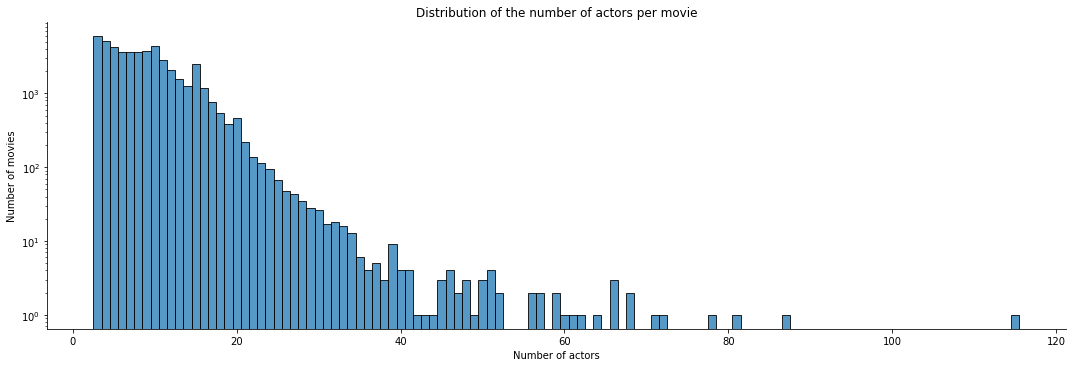

In [148]:
plot = sns.displot(actors['Wikipedia_movie_ID'], x=actors['Number_of_actors'],
                   log=True, discrete=True, aspect=3)
plot = plot.set(title='Distribution of the number of actors per movie',
                xlabel='Number of actors',
                ylabel='Number of movies')


# 3. Creating a network of actors

It's now time to creat a first network

## 3.1 Processing the data

In [149]:
# one actor per line in the new dataframe
actors_new_meta = actors.merge(character_metadata[[
    'Actor_name', 'Freebase_actor_ID', 'Wikipedia_movie_ID', 'Movie_release_year']], on='Wikipedia_movie_ID', how='inner')


In [41]:
actors_new_meta


,Wikipedia_movie_ID,Freebase_actor_IDs,Number_of_actors,Actor_name,Freebase_actor_ID,Movie_release_year
0,330,"[/m/0gh6sw, /m/0267qhz, /m/0263499, /m/0263yvy]",4,Rosa Maria Sardà,/m/0gh6sw,1996
1,330,"[/m/0gh6sw, /m/0267qhz, /m/0263499, /m/0263yvy]",4,Mercè Pons,/m/0267qhz,1996
2,330,"[/m/0gh6sw, /m/0267qhz, /m/0263499, /m/0263yvy]",4,Anna Lizaran,/m/0263499,1996
3,330,"[/m/0gh6sw, /m/0267qhz, /m/0263499, /m/0263yvy]",4,Núria Espert,/m/0263yvy,1996
4,3217,"[/m/07qn0, /m/0gmjf8, /m/01h8f, /m/01h8f, /m/0...",14,Ted Raimi,/m/07qn0,1992
...,...,...,...,...,...,...
427252,37478048,"[/m/0292l3, /m/03j367r, /m/067jsf, /m/06pwf6]",4,Sridevi Kapoor,/m/067jsf,1996
427253,37478048,"[/m/0292l3, /m/03j367r, /m/067jsf, /m/06pwf6]",4,Akkineni Nagarjuna,/m/06pwf6,1996
427254,37492363,"[/m/0g4tzm9, /m/0g4tzmn, /m/0g4tzm_]",3,Molly Cera,/m/0g4tzm9,2011
427255,37492363,"[/m/0g4tzm9, /m/0g4tzmn, /m/0g4tzm_]",3,Taylor Marie Milton,/m/0g4tzmn,2011


In [42]:
# dataframe with pairs of actors and the number of movies they acted in together
# the dataframe to merge contains all the actors_new_meta dataframe except the actors_names column
to_merge = actors_new_meta.drop('Freebase_actor_IDs', axis=1)
actors_pairs = to_merge.merge(
    to_merge, on=['Wikipedia_movie_ID', 'Number_of_actors', 'Movie_release_year'], how='inner')
# filter the dataframe to keep only the pairs where the actor ids are different
actors_pairs = actors_pairs[actors_pairs['Freebase_actor_ID_x']
                            != actors_pairs['Freebase_actor_ID_y']]
# filter the dataframe to keep only the pairs that are not interchangeable (actor1, actor2) and (actor2, actor1)
actors_pairs = actors_pairs[actors_pairs['Freebase_actor_ID_x']
                            < actors_pairs['Freebase_actor_ID_y']]


In [43]:
##### takes a long time to run (1m30s on my computer) #####

# for each pair make a new column with a dictionnary containing Wikipedia_movie_ID of the movies they acted in together as keys and the movie release year as values

actors_pairs_common_movies = actors_pairs.groupby(['Actor_name_x', 'Actor_name_y', 'Freebase_actor_ID_x', 'Freebase_actor_ID_y'])[[
    'Wikipedia_movie_ID', 'Movie_release_year']].apply(lambda x: dict(zip(x['Wikipedia_movie_ID'], x['Movie_release_year'].astype(int)))).reset_index().rename(columns={0: 'Common_movies'})




In [44]:
# number of common movies between each pair of actors
actors_pairs_common_movies['Number_of_common_movies'] = actors_pairs_common_movies['Common_movies'].apply(
    lambda x: len(x))


In [45]:
# filter the dataframe to keep only the pairs that acted in more than 2 movies together
actors_pairs_common_movies_filtered = actors_pairs_common_movies[
    actors_pairs_common_movies['Number_of_common_movies'] > 2]


In [46]:
actors_pairs_common_movies_filtered


,Actor_name_x,Actor_name_y,Freebase_actor_ID_x,Freebase_actor_ID_y,Common_movies,Number_of_common_movies
101,50 Cent,Ambyr Childers,/m/01vvyc_,/m/0f7tct,"{24150888: 2010, 31738289: 2011, 33638321: 2011}",3
148,50 Cent,Dr. Dre,/m/01vvyc_,/m/01vvydl,"{3914063: 2003, 6501095: 2003, 25010699: 1994}",3
285,50 Cent,Val Kilmer,/m/01vvyc_,/m/0d_84,"{19547540: 2009, 27211939: 2011, 30244564: 2010}",3
766,A. Michael Baldwin,Bill Thornbury,/m/0dm23j,/m/0k1vyv,"{1802400: 1979, 3305261: 1994, 3305282: 1998}",3
853,A. Venkatesh,Daggubati Venkatesh,/m/04n3wnz,/m/05yhh7,"{6827148: 2001, 14823527: 2008, 15398677: 1993...",4
...,...,...,...,...,...,...
2073805,高田由美,Chisa Yokoyama,/m/01vv6d4,/m/038277,"{4174679: 1999, 5396840: 1997, 5397050: 1996}",3
2073808,高田由美,Kikuchi Masami,/m/01vv6d4,/m/01wv1yt,"{4174679: 1999, 5396840: 1997, 5397050: 1996}",3
2073811,高田由美,Orikasa Kikue,/m/01vv6d4,/m/01wpgmk,"{4174679: 1999, 5396840: 1997, 5397050: 1996}",3
2073814,高田由美,Yuri Amano,/m/01vv6d4,/m/038cn3,"{4174679: 1999, 5396840: 1997, 5397050: 1996}",3


We want to create create temporal slices of the data the steps included are:

- get the year of the first and last movie in the dataset
- partition the dataset into slices where each slice contains all the movies released within or before a given year inside the interval

In [47]:
# get the year of the earliest movie in the dataset 
earliest_movie_year = actors_pairs_common_movies_filtered['Common_movies'].apply(lambda x: min(x.values())).min()
# get the year of the latest movie in the dataset
latest_movie_year = actors_pairs_common_movies_filtered['Common_movies'].apply(lambda x: max(x.values())).max()

print ('The movie dataset contains movies from {} to {}'.format(earliest_movie_year, latest_movie_year))

# create a dictionnary of datasets where the key is a given year and the value is the dataframe obtained by removing the common movies that were released after the given year
actor_pairs_by_year = {}
for year in range(earliest_movie_year, latest_movie_year+1):
    year_df = actors_pairs_common_movies_filtered.copy()
    # remove the common movies that were released after the given year
    year_df['Common_movies'] = year_df['Common_movies'].apply(lambda x: {k:v for k,v in x.items() if v <= year})
    # recalculate the number of common movies
    year_df['Number_of_common_movies'] = year_df['Common_movies'].apply(lambda x: len(x))
    # assign the dataframe to the dictionnary
    actor_pairs_by_year[year] = year_df

The movie dataset contains movies from 1899 to 2016


## 3.2 Creating the network

### 3.2.1 Global network 

There are many ways to create networks, a really common one is the networkx library. It offers lots of tools and we can easily find documentation on the web.

In [48]:
# create a non directed graph from the dataframe
G = nx.from_pandas_edgelist(actors_pairs_common_movies_filtered, source='Freebase_actor_ID_x',
                            target='Freebase_actor_ID_y', edge_attr='Number_of_common_movies')
# show the number of nodes and edges in the graph
print('Number of nodes: ', G.number_of_nodes())
print('Number of edges: ', G.number_of_edges())


Number of nodes:  8427
Number of edges:  25865


Now that we have the network we'll need to analyse it. The first step is to create subgroup using the louvain algorithm.
This step take a little bit time and doesn't give the exact same result. Therefor we created a csv file once to make the analyse on the same partitionning

In [49]:
# # select the number of simulations to run
# number_of_simulations = 100
# # make partitions of the graph
# best_coms = algorithms.louvain(G, weight='Number_of_common_movies')
# for i in range(0, number_of_simulations):
#     # make partitions of the graph
#     modularity = evaluation.newman_girvan_modularity(G, best_coms).score
#     coms = algorithms.louvain(G, weight='Number_of_common_movies', randomize=i)
#     # if the modularity is higher than the previous one then keep the partitions
#     if evaluation.newman_girvan_modularity(G, coms).score > modularity:
#         best_coms = coms
# 
# # print the modularity of the best partition
# print('Modularity: ', evaluation.newman_girvan_modularity(G, best_coms).score)
# # make subgraphs from the partitions
# subgraphs = [G.subgraph(c) for c in best_coms.communities]
# # show the number of subgraphs
# print('Number of communities: ', len(subgraphs))


The analyse of those communities will be done after on the notebook 

### 3.2.2 temporal version of the network ( a revoir)


- Identify: detect static communities on each step of evolution
- Match: align the communities found at step 'year' with the ones found at step year − 1, for each step.

In [50]:
# # Temporal clustering object
# tc = TemporalClustering()

# # identify the communities for each year
# for year in range(earliest_movie_year, latest_movie_year+1):
#     g = nx.from_pandas_edgelist(actor_pairs_by_year[year], source='Freebase_actor_ID_x',
#                             target='Freebase_actor_ID_y', edge_attr='Number_of_common_movies')
#     coms = algorithms.louvain(G, weight='Number_of_common_movies')
#     tc.add_clustering(coms, year)

In [51]:
# # match the communities between years using the jaccard similarity
# jaccard = lambda x, y:  len(set(x) & set(y)) / len(set(x) | set(y))
# matching = tc.community_matching(jaccard, two_sided=True)

## 3.3 Vizualising the network

Let's start the funny part with a basic visualization.

In [52]:
# vizualise the obtained partitions (top 10 communities)
# viz.plot_network_clusters(G, coms, node_size=20, figsize=(
#     20, 20), plot_labels=False, top_k=10)


In [53]:
# viz.plot_community_graph(G, coms, node_size=20, figsize=(
#     20, 20), plot_labels=False, top_k=10)


This is a nice visualization but didn't show us much more as the graph is very dense. <br>
A 3D one would be much better. We used the pyvis tool which is much nicer but didn't allow us to show communities

In [54]:
# g = net.Network(notebook = True)
# g.from_nx(G)
# g.show("example.html")


a new visualization was done on the website for the datastory

## 3.4 Analysing communities

### 3.4.1 intra-communities analysis

In [55]:
# show the number of nodes in each subgraph and the average weight of the edges in each subgraph (only for the top 20 subgraphs)
for i, subgraph in enumerate(subgraphs[:20]):
    print('community ', i + 1, ' number of actors                        :', subgraph.number_of_nodes())
    print('community ', i + 1, ' size                                    :', subgraph.size(weight='Number_of_common_movies'))
    print('community ', i + 1, ' assortativity of actors                 : %.4f' %nx.density(subgraph))
    print('community ', i + 1, ' average degree                          : %.2f' %(2*subgraph.number_of_edges()/subgraph.number_of_nodes()))
    print('community ', i + 1, ' average weighted degree                 : %.2f' %(2*subgraph.size(weight='Number_of_common_movies') / subgraph.number_of_nodes()))
    print('community ', i + 1, ' average numbers of movies between actors:',
          subgraph.size(weight='Number_of_common_movies') / subgraph.number_of_edges())


# store the sizes of communities
com_sizes = pd.DataFrame(columns=['community','size'])
for i, subgraph in enumerate(subgraphs):
    com_sizes = com_sizes.append({'community' : i+1, 'size' : subgraph.number_of_nodes()},ignore_index = True)


com_sizes.to_csv('./CSV_files/community_sizes.csv')

NameError: name 'subgraphs' is not defined

### 3.4.2 inter-community connections

In [56]:
# load data from tsv file to a pandas dataframe
actors_community = pd.read_csv('CSV_files/top_20_communities_scraping_done.csv')
actors_community = actors_community.drop(['connectivity', 'Wikidata_ID','actor_country_of_citizenship','actor_occupation'], axis=1)

In [57]:
# create df to count inter-community connections
actor_pairs = actors_pairs_common_movies_filtered.copy()
actor_pairs = actor_pairs.merge(actors_community, left_on='Freebase_actor_ID_x', right_on='Freebase_actor_ID', suffixes=('_1', '_2'))
actor_pairs = actor_pairs.merge(actors_community, left_on='Freebase_actor_ID_y', right_on='Freebase_actor_ID', suffixes=('_1', '_2'))
actor_pairs = actor_pairs.drop(['Freebase_actor_ID_1','Freebase_actor_ID_2'], axis = 1)
#actor_pairs = actor_pairs.query("Community_1 != Community_2")

# switch when com1<com2
actor_pairs['Community_1'], actor_pairs['Community_2'] = np.where(actor_pairs.Community_1>actor_pairs.Community_2,[actor_pairs.Community_2,actor_pairs.Community_1],[actor_pairs.Community_1,actor_pairs.Community_2])

# count number of movies and watch mean movies in common
actor_pairs = actor_pairs.groupby(['Community_1','Community_2']).agg(['count', 'mean']).reset_index()

#actor_pairs.columns = actor_pairs.columns.droplevel(0)
actor_pairs.columns = actor_pairs.columns.droplevel(0)
actor_pairs.columns = ['Community_1','Community_2','count', 'mean']

actor_pairs.to_csv('CSV_files/inter-communities-caracteristics.csv')

actor_pairs.head()


,Community_1,Community_2,count,mean
0,1,1,2468,3.539303
1,1,2,43,3.232558
2,1,4,67,3.119403
3,1,6,9,3.111111
4,1,7,103,3.300971


In [58]:
# create a non directed graph from the dataframe
G_communities = nx.from_pandas_edgelist(actor_pairs, source='Community_1',
                            target='Community_2', edge_attr='count')
#G_communities.add_node(11)
# show the number of nodes and edges in the graph
print('Number of nodes: ', G_communities.number_of_nodes())
print('Number of edges: ', G_communities.number_of_edges())

Number of nodes:  20
Number of edges:  69


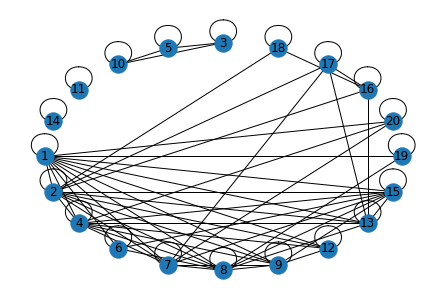

In [59]:
nx.draw_shell(G_communities, with_labels = True)

### 3.4.3 old analyse from M2

If we aim to see tendencies between those subgroup, we'll need to add features to nodes.

In [60]:
# for n in G.nodes:
#     G.nodes[n]['actor_gender'] = character_metadata[character_metadata.Freebase_actor_ID ==
#                                                     n]['actor_gender'].iloc[0]



We can now compute the assortativity  for certains properties. It measures the similarity of connections in the graph with respect to the given attribute.

In [61]:
# print("gender assortativity: ",
#       nx.attribute_assortativity_coefficient(G, 'actor_gender'))


In [62]:
# store the top 20 communities in dataframes
# each row in the dataframe is an actor in the community, the connectivity column represents the total weight of the edges that the actor is connected to
# i.e the total number of movies the actor acted in with the other actors in the community
top_20_communities = []
for i, subgraph in enumerate(subgraphs[:20]):
    top_20_communities.append(pd.DataFrame(subgraph.degree(weight='Number_of_common_movies'), columns=[
                              'Actor_name', 'connectivity']).sort_values('connectivity', ascending=False))


NameError: name 'subgraphs' is not defined

In [ ]:
character_metadata

In [63]:
# for each community add columns for actors ethnicity, gender and date of birth from the character_metadata dataframe
# for i, community in enumerate(top_20_communities):
#     top_20_communities[i] = community.merge(character_metadata[['Actor_name', 'actor_gender', 'Actor_date_of_birth',                                          ### Actor birth not in df
#                                             ]], on='Actor_name', how='inner').drop_duplicates(subset=['Actor_name']).reset_index(drop=True)
#     top_20_communities[i]['community'] = i + 1
# top_20_communities_all_actors = pd.concat(
#     top_20_communities).reset_index(drop=True)


In [64]:
# G2 = nx.connected_watts_strogatz_graph(30, 5, .2)
# nodes = G2.nodes()
# edges = list(G2.edges(data=True))


Additionnally from observing actors in each communities, we would like to include in our communities' analysis the movies within each community, i.e. the movies that connect actors together within a single community. For this purpose, we start by mapping movies' occurencies for each community. 
Later on, we can use this table to analyze the number of movies within each community, whether a movie appears in only one, or several communities, and also add movies features such as genre, length or date of release. 

In [65]:
# movies_com_list = pd.DataFrame(columns=['movie_index', 'community'])

# # first we extract for each edge in a subgraph the corresponding movies and store in a dataframe the movie index and the community
# for community_nb in range(1, 21):
#     for x in subgraphs[community_nb-1].edges:
#         movies = actors_pairs_common_movies_filtered.loc[(actors_pairs_common_movies_filtered['Freebase_actor_ID_x'] == x[0])
#                                                          & (actors_pairs_common_movies_filtered['Freebase_actor_ID_y'] == x[1])].Common_movies
#         if len(movies) == 0:
#             movies = actors_pairs_common_movies_filtered.loc[(actors_pairs_common_movies_filtered['Freebase_actor_ID_x'] == x[1])
#                                                              & (actors_pairs_common_movies_filtered['Freebase_actor_ID_y'] == x[0])].Common_movies
#         if len(movies) == 0:
#             print('error')
#         for liste in movies:
#             for elt in liste:
#                 movies_com_list = movies_com_list.append(pd.DataFrame([[int(elt), int(
#                     community_nb)]], columns=['movie_index', 'community']), ignore_index=True)

# # data rearranged to have each movie as a row, and each community as a column. the value describes the numbers of edges referring to a movie within the specified community
# movie_com_table = movies_com_list.pivot_table(
#     columns='community', index='movie_index', aggfunc=len, fill_value=0)
# movie_com_table.to_csv('./CSV_files/movies_communities_table.csv')


In [66]:
# movie_com_table

In [67]:
# Aggregate this information with the features of each movie
# movies_com_metadata = pd.merge(
#     movies_metadata, movie_com_table, left_on='Wikipedia_movie_ID', right_on='movie_index')
# movies_com_metadata.to_csv('./CSV_files/movies_communities_metadata.csv')


## 3.5 Preprocessing of scraped data 

The dataframe used in this section is the dataframe produced by the file "scraping.ipynb" . 
This dataframe is based on an older and no longer valid version of our top 20 communities . 
<br /> The scraping was done only on the cast of actors of those communities for time constraints but our network have changed in the meantime. So this is just an example of how we would preprocess the data obtained from scraping ,  namely "actor_country_of_citizenship" and "actor_occupation".

In [51]:
# load actor dataframe after scraping
actors_scraping = pd.read_csv(
    'CSV_files/top_20_communities_scraping_done.csv')
# add gender info to the dataframe
actors_scraping = actors_scraping.merge(character_metadata[['Freebase_actor_ID', 'actor_gender']], on='Freebase_actor_ID', how='inner').drop_duplicates(subset=['Freebase_actor_ID']).reset_index(drop=True)

# make a table with the movies as rows (wikidata movie id should be index) and the communities as columns, the value is the number of actors in the community that acted in the movie
movies = pd.DataFrame(character_metadata.Wikipedia_movie_ID.unique(), columns=['Wikipedia_movie_ID'])
communities = pd.DataFrame(range(1, 21), columns=['community'])
movies_com_table = pd.DataFrame(index=movies.Wikipedia_movie_ID, columns=communities.community, data=0)

# get the dictionnary of freebase actor ids for each community
actors_dict = {}
for community_nb in range(1, 21):
    actors_dict[community_nb] = list(
        actors_scraping[actors_scraping.Community == community_nb].Freebase_actor_ID)


# for each community, for each movie, count the number of actors in the community that acted in the movie (from character_metadata)
for community_nb in range(1, 21):
    movies_com_table.loc[:, community_nb] = character_metadata.loc[character_metadata.Freebase_actor_ID.isin(actors_dict[community_nb])].groupby("Wikipedia_movie_ID").size()
    # NaN values are replaced by 0
    movies_com_table.loc[:, community_nb] = movies_com_table.loc[:, community_nb].fillna(0)

# remove the lines that do not contain at least two actors from a community
movies_com_table = movies_com_table[movies_com_table.max(axis=1) > 1]

# save the table
movies_com_table.to_csv('./CSV_files/movies_communities_table_scraping_done.csv')

movies_com_table


community,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Wikipedia_movie_ID,,,,,,,,,,,,,,,,,,,,
975900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
2314463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
175026,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
612710,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
156558,0.0,0.0,0.0,0.0,0.0,0.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22330502,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21772949,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24997872,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
# Aggregate this information with the features of each movie
movies_com_metadata = pd.merge(
    movies_metadata, movies_com_table, on='Wikipedia_movie_ID')

# save the table
movies_com_metadata.to_csv('./CSV_files/movies_communities_metadata_scraping_done.csv')

### Country of citizenship cleaning 

In [53]:
# extract unique country names
unique_countries = actors_scraping['actor_country_of_citizenship'].unique()
unique_countries


array(['United States of America', 'Canada', 'United Kingdom', 'Scotland',
       "People's Republic of China", 'Australia', nan, 'Puerto Rico',
       'France', 'Sweden', 'Austria', 'Belgium', 'New Zealand',
       'Venezuela', 'South Africa', 'Italy', 'Spain', 'Honduras',
       'Republic of Ireland', 'Germany', 'Mexico', 'Cuba', 'Brazil',
       'Colombia', 'Denmark', 'Hungary', 'Soviet Union', 'Romania',
       'Kingdom of Romania',
       'United Kingdom of Great Britain and Ireland',
       'Dominican Republic', 'Portugal', 'Kingdom of Hungary',
       'Russian Empire', 'Russia', 'Ottoman Empire', 'Japan', 'Croatia',
       'Greece', 'Crown Colony of Malta', 'German Empire',
       'Kingdom of the Netherlands', 'Switzerland', 'England', 'Dominica',
       'Poland', 'India', 'British Raj', 'Pakistan', 'Nepal', 'Sri Lanka',
       'Norway', 'Wales', 'Egypt', 'Argentina', 'Slovenia', 'Lithuania',
       'Armenia', 'Bhutan', 'British Hong Kong', 'Hong Kong', 'Taiwan',
       'Singapo

We can see that we have some countries that are named in more than way ; Hungary / Kingdom of Hungary , United Kingdom of Great Britain / England / United Kingdom , Russia / Soviet Union ... <br /> We tried to use again a sequence matcher but it didn't hold much results , we will have to regroup manually the concerned countires. <br /> Old country names such as "Ottoman Empire","Soviet Union","British Raj" have been renamed to their modern names

In [54]:
# function that outputs a similarity score between strings
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()


In [55]:
# apply the similarity function on unique country names obtained
matches = []
for n in unique_countries:
    for x in unique_countries:
        if n != x:
            match = similar(str(n), str(x))
            if match > 0.5:
                matches.append(['match score =', "%.2f" %
                               match, str(n)+' / '+str(x)])
matches[2:10]


[['match score =', '0.53', 'Scotland / England'],
 ['match score =', '0.71', 'Scotland / Poland'],
 ['match score =', '0.53', 'Scotland / Finland'],
 ['match score =', '0.58', "People's Republic of China / Republic of Ireland"],
 ['match score =', '0.79', "People's Republic of China / Republic of China"],
 ['match score =', '0.88', 'Australia / Austria'],
 ['match score =', '0.53', 'Australia / Russia'],
 ['match score =', '1.00', 'nan / nan']]

In [56]:
# Merge concerned countries into unique key countries
countries_wordsets = dict([
    ('United Kingdom', [
     'United Kingdom of Great Britain and Ireland', 'Scotland', 'England', 'Wales']),
    ('Ireland', ['Republic of Ireland']),
    ('Russia', ['Soviet Union', 'Russian Empire']),
    ('Romania', ['Kingdom of Romania']),
    ('Hungary', ['Kingdom of Hungary']),
    ('China', ['Republic of China', 'People\'s Republic of China']),
    ('Italy', ['Kingdom of Italy']),
    ('Hong Kong', ['British Hong Kong']),
    ('India', ['British Raj']),
    ('Germany', ['German Empire']),
    ('Netherlands', ['Kingdom of the Netherlands']),
    ('Malta', ['Crown Colony of Malta']),
    ('Turkey', ['Ottoman Empire'])
])


Now that we have a dictionary that can normalize country names , all we have to do is replace the problematic country names with their correspondant name .

In [57]:
actors_scraping['actor_country_of_citizenship'] = actors_scraping['actor_country_of_citizenship'].apply(
    lambda x:  [k for k, v in countries_wordsets.items() if x in v][0] if len([k for k, v in countries_wordsets.items() if x in v]) != 0 else x)
actors_scraping['actor_country_of_citizenship'].value_counts()


United States of America    2747
India                       1171
United Kingdom               730
Japan                        236
China                        137
Canada                       126
France                       117
Italy                         65
Sweden                        59
Australia                     55
Ireland                       49
Hong Kong                     42
Germany                       29
Spain                         28
New Zealand                   23
Taiwan                        23
Mexico                        15
Egypt                         12
Austria                        9
Portugal                       9
Puerto Rico                    7
Russia                         6
Hungary                        5
Belgium                        5
Pakistan                       4
South Korea                    4
South Africa                   4
Netherlands                    3
Norway                         3
Switzerland                    3
Venezuela 

### Occupation preprocessing

The occupation column is a list of occupations in string format . 
<br /> The first step is to eliminate non desired characters from the string such as ' , [ , ] 

In [58]:
# extract a list from actor_occupations column
list_occupations = list(actors_scraping['actor_occupation'])
# function that extracts occupations from string of occupations


def extract_occupation(string):
    occupation_list = ""
    if isinstance(string, str):
        string = string.replace("'", "")
        string = string.replace("[", "")
        string = string.replace("]", "")
        occupation_list = string.split(",")

    return occupation_list


occupations_with_dupilicate = []
# get a list of all occupations with duplicates
for s in list_occupations:
    split_string = extract_occupation(s)
    split_string = [x.strip() for x in split_string]
    occupations_with_dupilicate.append(split_string)


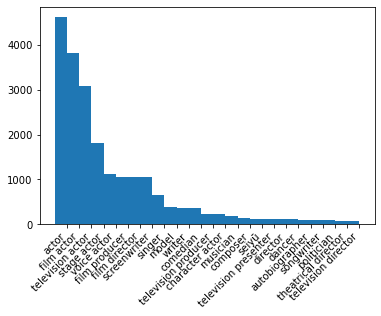

In [59]:
# get a list of unique occupations
occupations_unique = Counter(
    [item for sublist in occupations_with_dupilicate for item in sublist])
top_25_occupations = occupations_unique.most_common(25)

labels = [i[0] for i in top_25_occupations]
values = [i[1] for i in top_25_occupations]
indexes = np.arange(len(top_25_occupations))
width = 1
# plot histogram of top 25 occupations distribution
plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.xticks(rotation=45, ha='right')
plt.show()


We can observe here the 25 most common occupations . <br /> We can see that for the "actor" occupation for example, there are a lot of variations like "film actor" , "stage actor" ... <br />These differences will induce non desired variance between actor occupation , for this reason , we aim here to regroup the different occupation into key occupations that would better represent specific communities . <br /> To be sure to take into account most relevant occupations , we are going to consider the top 50 occupations present in our communities and label them and replace all remaining occupations with "other"

In [60]:
# get a list of unique occupations
occupations_unique.most_common(50)


[('actor', 4613),
 ('film actor', 3813),
 ('television actor', 3083),
 ('stage actor', 1811),
 ('voice actor', 1122),
 ('film producer', 1061),
 ('film director', 1058),
 ('screenwriter', 1052),
 ('singer', 665),
 ('model', 396),
 ('writer', 368),
 ('comedian', 362),
 ('television producer', 238),
 ('character actor', 224),
 ('musician', 192),
 ('composer', 136),
 ('seiyū', 129),
 ('television presenter', 122),
 ('director', 118),
 ('dancer', 110),
 ('autobiographer', 108),
 ('songwriter', 89),
 ('politician', 89),
 ('theatrical director', 83),
 ('television director', 79),
 ('recording artist', 74),
 ('singer-songwriter', 70),
 ('dub actor', 67),
 ('radio personality', 63),
 ('manufacturer', 60),
 ('film editor', 52),
 ('playwright', 47),
 ('stunt performer', 47),
 ('beauty pageant contestant', 45),
 ('journalist', 43),
 ('businessperson', 42),
 ('guitarist', 37),
 ('author', 37),
 ('stand-up comedian', 36),
 ('novelist', 34),
 ('rapper', 34),
 ('executive producer', 33),
 ('poet', 32

In [61]:
# Merge top 50 occupations into unique key occupations
occupation_wordsets = dict([
    ('actor', ['actor', 'film actor',
     'television actor', 'stage actor', 'child actor']),
    ('voice actor', ['voice actor', 'dub actor']),
    ('director', ['director', 'film director',
     'theatrical director', 'television director']),
    ('musician', ['singer', 'musician', 'yodeler', 'songwriter', 'rapper',
                  "guitarist", "recording artist", "record producer", "singer-songwriter", 'jazz musician']),
    ('producer', ['producer', 'film producer', 'television producer', 'film editor']),
    ('writer', ['screenwriter', 'novelist', 'author', 'playwright', 'writer',
                "autobiographer"]),
    ('dancer', ['dancer', 'ballet dancer']),
    ('model', ['model', 'beauty pageant contestant']),
    ('athlete', ['American football player', 'stunt performer', 'athlete']),
    ('presenter', ['radio personality', 'presenter','animator']),
    ('artist', ['painter', 'sculptor', 'poet', 'painter','photographer']),
    ('politician', ['military officer', 'military personnel', 'politician']),
    ('comedian', ['comedian', 'stand-up comedian', 'podcaster']),
    ('businessperson', ['businessman', 'businesswoman',
     'businessperson', 'entrepreneur']),
    ('journalist', ['journalist'])
])


In [62]:
# split occupation string into list of strings
actors_scraping['actor_occupation']=actors_scraping['actor_occupation'].apply(extract_occupation)

In [63]:
# strip actor_occupation list of whitespaces
actors_scraping['actor_occupation'] = actors_scraping['actor_occupation'].apply(
    lambda x: [i.strip() for i in x])


In [64]:
# create a new collumn occupation_filtered where you group the occupations into the keys of occupation_wordsets
actors_scraping['occupation_filtered'] = actors_scraping['actor_occupation'].apply(
    lambda x: [k for k, v in occupation_wordsets.items() if any(i in v for i in x)] if len([k for k, v in occupation_wordsets.items() if any(i in v for i in x)]) != 0 else x)
actors_scraping['occupation_filtered'].value_counts()

[actor]                                                   2487
[actor, voice actor]                                       291
[]                                                         273
[actor, director]                                          220
[actor, musician]                                          210
                                                          ... 
[actor, musician, writer, presenter, artist, comedian]       1
[actor, musician, dancer, model]                             1
[actor, director, musician, politician, comedian]            1
[actor, voice actor, musician, writer, businessperson]       1
[biathlete]                                                  1
Name: occupation_filtered, Length: 359, dtype: int64

Now that we have a clear classification of the occupations and countries , we can characterize the communities

### Communities characterization

In [65]:
def aggregate_occupation(column):

    return pd.Series([x for item in column for x in item]).value_counts(normalize=True)


In [66]:
communities_feature = pd.DataFrame(columns=['Community', 'Males_%', 'Females_%', '1st_country','1st_country_%','2nd_country', 
                                       '2nd_country_%', '3rd_country','3rd_country_%', '1st_occupation','1st_occupation_%', '2nd_occupation','2nd_occupation_%', '3rd_occupation','3rd_occupation_%'])
for i in range(0, 20):
    df = actors_scraping[actors_scraping['Community'] == i+1]
    gender_distribution = df['actor_gender'].value_counts(normalize=True) * 100
    country_distribution_labels = df['actor_country_of_citizenship'].value_counts(
        normalize=True).index.tolist()
    country_distribution_values = df['actor_country_of_citizenship'].value_counts(
        normalize=True)*100
    occupation_distribution_labels = aggregate_occupation(df['occupation_filtered']).index.tolist()
    occupation_distribution_values = aggregate_occupation(df['occupation_filtered'])*100
    # fill the communities_feature dataframe
    communities_feature.at[i,'Community']=i+1
    communities_feature.at[i,'Males_%']=gender_distribution.M
    communities_feature.at[i,'Females_%']=gender_distribution.F
    # We take the top 3 countries and top 3 occupations for each community , we don't consider actor occupation since it's number 1 in all communities
    if len(country_distribution_values) >= 3:
        communities_feature.at[i,'1st_country_%']=country_distribution_values[0]
        communities_feature.at[i,'2nd_country_%']=country_distribution_values[1]
        communities_feature.at[i,'3rd_country_%']=country_distribution_values[2]
        communities_feature.at[i,'1st_country']=country_distribution_labels[0]
        communities_feature.at[i,'2nd_country']=country_distribution_labels[1]
        communities_feature.at[i,'3rd_country']=country_distribution_labels[2]
    elif len(country_distribution_values) == 2 :
        communities_feature.at[i,'1st_country_%']=country_distribution_values[0]
        communities_feature.at[i,'2nd_country_%']=country_distribution_values[1]
        communities_feature.at[i,'3rd_country_%']=0
        communities_feature.at[i,'1st_country']=country_distribution_labels[0]
        communities_feature.at[i,'2nd_country']=country_distribution_labels[1]
        communities_feature.at[i,'3rd_country']=0
    else :
        communities_feature.at[i,'1st_country_%']=country_distribution_values[0]
        communities_feature.at[i,'2nd_country_%']=0
        communities_feature.at[i,'3rd_country_%']=0
        communities_feature.at[i,'1st_country']=country_distribution_labels[0]
        communities_feature.at[i,'2nd_country']=0
        communities_feature.at[i,'3rd_country']=0
    communities_feature.at[i,'1st_occupation_%']=occupation_distribution_values[1]
    communities_feature.at[i,'2nd_occupation_%']=occupation_distribution_values[2]
    communities_feature.at[i,'3rd_occupation_%']=occupation_distribution_values[3]
    communities_feature.at[i,'1st_occupation']=occupation_distribution_labels[1]
    communities_feature.at[i,'2nd_occupation']=occupation_distribution_labels[2]
    communities_feature.at[i,'3rd_occupation']=occupation_distribution_labels[3]



In [67]:
communities_feature

,Community,Males_%,Females_%,1st_country,1st_country_%,2nd_country,2nd_country_%,3rd_country,3rd_country_%,1st_occupation,1st_occupation_%,2nd_occupation,2nd_occupation_%,3rd_occupation,3rd_occupation_%
0,1,67.936803,32.063197,United States of America,86.862004,United Kingdom,4.442344,Canada,3.875236,voice actor,14.676082,producer,13.66288,writer,12.588271
1,2,67.828685,32.171315,United States of America,80.645161,United Kingdom,9.677419,Canada,3.125,writer,10.466989,musician,7.246377,director,7.1927
2,3,59.223301,40.776699,India,96.784566,United Kingdom,1.286174,Pakistan,0.482315,director,10.881295,producer,8.453237,model,8.453237
3,4,72.953737,27.046263,United Kingdom,64.579606,United States of America,14.31127,Australia,7.155635,writer,10.410697,producer,7.354346,director,7.067813
4,5,65.068493,34.931507,India,99.02439,Egypt,0.243902,Bhutan,0.243902,director,9.710145,producer,8.695652,writer,5.797101
5,6,72.623574,27.376426,China,58.441558,Hong Kong,18.181818,Taiwan,9.95671,musician,15.702479,director,12.809917,writer,6.61157
6,7,66.911765,33.088235,United States of America,88.973384,Canada,6.463878,United Kingdom,3.422053,voice actor,28.517588,musician,9.170854,writer,7.788945
7,8,70.0,30.0,United States of America,74.81203,United Kingdom,6.390977,Spain,6.390977,producer,12.768647,voice actor,12.389381,writer,10.745891
8,9,69.072165,30.927835,United Kingdom,77.15736,Ireland,7.614213,United States of America,7.106599,voice actor,12.149533,writer,11.214953,producer,8.411215
9,10,59.763314,40.236686,India,100.0,0,0,0,0,director,10.852713,writer,7.751938,producer,5.813953


In [68]:
# save communties features in csv files folder
communities_feature.to_csv('./CSV_files/communities_features.csv', index=False)

In [69]:
# df = top_20_communities_all_actors.groupby('community')

# df_fill = df.agg('count')
# # df_fill[['connectivity','actor_gender','Actor_date_of_birth','Actor_ethnicity']]/4
# df_fill['actor_gender'] = df_fill.apply(
#     lambda r: r.actor_gender/r.Actor_name*100, axis=1)
# df_fill['connectivity'] = df_fill.apply(
#     lambda r: r.connectivity / r.Actor_name*100, axis=1)
# df_fill['Actor_date_of_birth'] = df_fill.apply(
#     lambda r: r.Actor_date_of_birth/r.Actor_name*100, axis=1)
# df_fill['Actor_ethnicity'] = df_fill.apply(
#     lambda r: r.Actor_ethnicity/r.Actor_name*100, axis=1)
# df_fill

# # gender is always here
# # date of birth never less than 70%
# # ethnicity very small representation (no more than 60% values)


## 3.6 Gapminder sytle visualization

### 3.6.1 Fill missing values

In [88]:
# for each actor in actors scraping we will get the names of the actors from the character metadata dataframe

to_merge = character_metadata[['Actor_name', 'Freebase_actor_ID', 'Actor_date_of_birth']]
to_merge = to_merge.drop_duplicates()

actors_dataframe = pd.merge(actors_scraping, to_merge, on='Freebase_actor_ID', how='left')

In [89]:
actors_dataframe

,Freebase_actor_ID,connectivity,Community,Wikidata_ID,actor_country_of_citizenship,actor_occupation,actor_gender,occupation_filtered,Actor_name,Actor_date_of_birth
0,/m/0f5xn,157,1,Q172678,United States of America,"[film actor, actor, film producer, voice actor...",M,"[actor, voice actor, producer]",Samuel L. Jackson,1948-12-21
1,/m/028k57,128,1,Q312129,Canada,"[screenwriter, film actor, actor, film produce...",M,"[actor, voice actor, director, musician, produ...",Eugene Levy,1946-12-17
2,/m/01vy_v8,125,1,Q311319,United States of America,"[film director, actor, puppeteer, screenwriter...",M,"[actor, voice actor, director, writer]",Frank Oz,1944-05-25
3,/m/0pz91,123,1,Q132952,United States of America,"[actor, television actor, film actor, film pro...",M,"[actor, voice actor, musician, producer, write...",Adam Sandler,1966-09-09
4,/m/01wbg84,123,1,Q104061,United States of America,"[television actor, film actor, film director, ...",M,"[actor, voice actor, director, producer, writer]",Steve Buscemi,1957-12-13
...,...,...,...,...,...,...,...,...,...,...
6072,/m/0bx63ms,3,20,NaN,NaN,[],NaN,[],Pierre Lindstedt,NaN
6073,/m/04bdlg,3,20,Q318885,Japan,"[stage actor, film actor, television actor, ac...",M,[actor],Mako,1933-12-10
6074,/m/0c3l2x,3,20,Q3427943,Sweden,"[actor, musician, singer]",M,"[actor, musician]",Rikard Wolff,1958-04-08
6075,/m/02wx5q5,3,20,NaN,NaN,[],M,[],Åke Grönberg,1914-03-26


In [91]:

actors_dataframe = actors_dataframe[['Actor_name', 'actor_gender', 'Actor_date_of_birth',
                                    'Freebase_actor_ID', 'Wikidata_ID', 'actor_country_of_citizenship', 'Community', 'actor_occupation']]
# print the number of missing values in each column feature
print('the number of missing values in actor_name column is',
      actors_dataframe['Actor_name'].isnull().sum())
print('the number of missing values in the actor gender column is',
      actors_dataframe['actor_gender'].isnull().sum())
print('the number of missing values in actor_date_of_birth column is',
      actors_dataframe['Actor_date_of_birth'].isnull().sum())
print('the number of missing values in freebase_actor_id column is',
      actors_dataframe['Freebase_actor_ID'].isnull().sum())
print('the number of missing values in Wikidata_ID column is',
      actors_dataframe['Wikidata_ID'].isnull().sum())
print('the number of missing values in actor_country_of_citizenship column is',
      actors_dataframe['actor_country_of_citizenship'].isnull().sum())
print('the number of missing values in Community column is',
      actors_dataframe['Community'].isnull().sum())
print('the number of missing values in actor_occupation column is',
      actors_dataframe['actor_occupation'].isnull().sum())


the number of missing values in actor_name column is 0
the number of missing values in the actor gender column is 54
the number of missing values in actor_date_of_birth column is 564
the number of missing values in freebase_actor_id column is 0
the number of missing values in Wikidata_ID column is 273
the number of missing values in actor_country_of_citizenship column is 315
the number of missing values in Community column is 0
the number of missing values in actor_occupation column is 0


In [93]:
# function to extract the year from the date of birth
def extract_year(date_of_birth):
    if date_of_birth is not None:
        # convert to string
        date_of_birth = str(date_of_birth)
        if '-' in date_of_birth:
            date = date_of_birth.split('-')
        else :
            date = date_of_birth.split('/')
        # the year of birth is the substring of length 4 among the date substrings
        for string in date:
            if len(string) == 4:
                return int(string)

# apply the function to the date of birth column
actors_dataframe['Year_of_birth'] = actors_dataframe['Actor_date_of_birth'].apply(extract_year)
# sanity check: assert that number of missing values in the year of birth column is equal to the number of missing values in the date of birth column
assert actors_dataframe['Year_of_birth'].isnull().sum() == actors_dataframe['Actor_date_of_birth'].isnull().sum()
# drop the date of birth column
actors_dataframe.drop('Actor_date_of_birth', axis=1, inplace=True)
    

In [100]:
# fill the year of birth column with the median value of the year of birth from the same community which are not missing
actors_dataframe['Year_of_birth'] = actors_dataframe.groupby(
    'Community')['Year_of_birth'].apply(lambda x: x.fillna(x.median()))


In [101]:
# fill the missing gender values randomly with the probability of each within the same community
gender_probabilities = actors_dataframe.groupby(
    'Community')['actor_gender'].value_counts(normalize=True)
actors_dataframe['actor_gender'] = actors_dataframe.groupby('Community')['actor_gender'].apply(
    lambda x: x.fillna(np.random.choice(['M', 'F'], p=gender_probabilities[x.name])))
# fill the missing country of citizenship values randomly with the probability of each within the same community
actors_dataframe['actor_country_of_citizenship'] = actors_dataframe.groupby('Community')['actor_country_of_citizenship'].apply(
    lambda x: x.fillna(np.random.choice(x.value_counts().index, p=x.value_counts(normalize=True).values)))
# fill the missing occupation values with a list containing a single string 'actor'
actors_dataframe['actor_occupation'] = actors_dataframe['actor_occupation'].fillna(
    "['actor']")


### 3.6.2 Preprocessing the data

#### 3.6.2.1 movies

In [150]:
# drop the rows where the freebase actor id is not present in actors_dataframe
actors_movies = actors_new_meta[actors_new_meta['Freebase_actor_ID'].isin(
    actors_dataframe['Freebase_actor_ID'])]
# sanity check: assert every actor in actors_dataframe is present in actors_movies
assert set(actors_dataframe['Freebase_actor_ID']) == set(
    actors_movies['Freebase_actor_ID'])


In [151]:
##### take a long time to run (about 1m 9s on my computer) #####

# for each actor in actors_dataframe, make a new coloumn in actors_movies representing a dictionnary with Wikipedia_movie_ID  as key and the movie release year as value
actors_dataframe['movies'] = actors_dataframe['Freebase_actor_ID'].apply(lambda x: dict(zip(
    actors_movies[actors_movies['Freebase_actor_ID'] == x]['Wikipedia_movie_ID'], actors_movies[actors_movies['Freebase_actor_ID'] == x]['Movie_release_year'].astype(int))))


In [152]:
actors_dataframe


,Actor_name,actor_gender,Freebase_actor_ID,Wikidata_ID,actor_country_of_citizenship,Community,actor_occupation,Year_of_birth,movies
0,Samuel L. Jackson,M,/m/0f5xn,Q172678,United States of America,1,"[film actor, actor, film producer, voice actor...",1948.0,"{32252: 2000, 50793: 1999, 50957: 2002, 54173:..."
1,Eugene Levy,M,/m/028k57,Q312129,Canada,1,"[screenwriter, film actor, actor, film produce...",1946.0,"{155303: 1981, 167924: 2002, 241471: 2001, 241..."
2,Frank Oz,M,/m/01vy_v8,Q311319,United States of America,1,"[film director, actor, puppeteer, screenwriter...",1944.0,"{50744: 1983, 50793: 1999, 50957: 2002, 53964:..."
3,Adam Sandler,M,/m/0pz91,Q132952,United States of America,1,"[actor, television actor, film actor, film pro...",1966.0,"{227291: 2002, 340276: 1998, 400797: 1996, 454..."
4,Steve Buscemi,M,/m/01wbg84,Q104061,United States of America,1,"[television actor, film actor, film director, ...",1957.0,"{11242: 2001, 29782: 1998, 52390: 1998, 54173:..."
...,...,...,...,...,...,...,...,...,...
6072,Pierre Lindstedt,M,/m/0bx63ms,NaN,Sweden,20,[],1930.0,"{101906: 1971, 5230828: 1972, 28116713: 1973}"
6073,Mako,M,/m/04bdlg,Q318885,Japan,20,"[stage actor, film actor, television actor, ac...",1933.0,"{98508: 1966, 214148: 2003, 242542: 1983, 6659..."
6074,Rikard Wolff,M,/m/0c3l2x,Q3427943,Sweden,20,"[actor, musician, singer]",1958.0,"{844425: 1992, 2649800: 2001, 8455434: 2006, 1..."
6075,Åke Grönberg,M,/m/02wx5q5,NaN,Sweden,20,[],1914.0,"{4838538: 1953, 8072901: 1954, 11380181: 1955}"


#### 3.6.2.2 countries

In [153]:
# show the list of unique countries in the dataset
actors_dataframe['actor_country_of_citizenship'].unique()
# map countries to coutnries codes using pycountry (make dictionary of countries and codes)
countries = actors_dataframe['actor_country_of_citizenship'].unique()
countries_codes = dict()
for country in countries:
    try:
        countries_codes[country] = pycountry.countries.search_fuzzy(country)[
            0].alpha_2
    except LookupError:
        countries_codes[country] = None
# get the number of missing values in the country codes
print('the number of missing values in the country codes is', sum(
    [1 for code in countries_codes.values() if code is None]))


the number of missing values in the country codes is 0


In [154]:
# make a new column in actors_dataframe representing the country codes
actors_dataframe['country_codes'] = actors_dataframe['actor_country_of_citizenship'].map(
    countries_codes)


In [155]:
# using the faker library, generate random longitude and latitude for each actor based on the country code
fake = Faker()
Faker.seed(4321)
actors_dataframe['lat_long'] = actors_dataframe['country_codes'].apply(
    lambda x: fake.local_latlng(country_code=x, coords_only=True) if x is not None else None)
# split the long_lat column into two columns: longitude and latitude
actors_dataframe[['latitude', 'longitude']] = pd.DataFrame(
    actors_dataframe['lat_long'].tolist(), index=actors_dataframe.index)
# drop the long_lat column
actors_dataframe.drop('lat_long', axis=1, inplace=True)


In [156]:
actors_dataframe


,Actor_name,actor_gender,Freebase_actor_ID,Wikidata_ID,actor_country_of_citizenship,Community,actor_occupation,Year_of_birth,movies,country_codes,latitude,longitude
0,Samuel L. Jackson,M,/m/0f5xn,Q172678,United States of America,1,"[film actor, actor, film producer, voice actor...",1948.0,"{32252: 2000, 50793: 1999, 50957: 2002, 54173:...",US,42.24113,-88.3162
1,Eugene Levy,M,/m/028k57,Q312129,Canada,1,"[screenwriter, film actor, actor, film produce...",1946.0,"{155303: 1981, 167924: 2002, 241471: 2001, 241...",CA,45.43341,-73.86586
2,Frank Oz,M,/m/01vy_v8,Q311319,United States of America,1,"[film director, actor, puppeteer, screenwriter...",1944.0,"{50744: 1983, 50793: 1999, 50957: 2002, 53964:...",US,43.1009,-75.23266
3,Adam Sandler,M,/m/0pz91,Q132952,United States of America,1,"[actor, television actor, film actor, film pro...",1966.0,"{227291: 2002, 340276: 1998, 400797: 1996, 454...",US,33.08014,-83.2321
4,Steve Buscemi,M,/m/01wbg84,Q104061,United States of America,1,"[television actor, film actor, film director, ...",1957.0,"{11242: 2001, 29782: 1998, 52390: 1998, 54173:...",US,32.44874,-99.73314
...,...,...,...,...,...,...,...,...,...,...,...,...
6072,Pierre Lindstedt,M,/m/0bx63ms,NaN,Sweden,20,[],1930.0,"{101906: 1971, 5230828: 1972, 28116713: 1973}",SE,59.33333,18.28333
6073,Mako,M,/m/04bdlg,Q318885,Japan,20,"[stage actor, film actor, television actor, ac...",1933.0,"{98508: 1966, 214148: 2003, 242542: 1983, 6659...",JP,34.25,135.31667
6074,Rikard Wolff,M,/m/0c3l2x,Q3427943,Sweden,20,"[actor, musician, singer]",1958.0,"{844425: 1992, 2649800: 2001, 8455434: 2006, 1...",SE,59.33333,18.28333
6075,Åke Grönberg,M,/m/02wx5q5,NaN,Sweden,20,[],1914.0,"{4838538: 1953, 8072901: 1954, 11380181: 1955}",SE,59.33333,18.28333


# function that given a country attributes longitude and latitude that are within the country
# def get_country_coordinates(country):
#### 3.6.2.3 time slices

In [328]:
# across all actors get the earliest and latest movie release year
earliest_movie_year = actors_dataframe['movies'].apply(
    lambda x: min(x.values())).min()
latest_movie_year = actors_dataframe['movies'].apply(
    lambda x: max(x.values())).max()
print('the movie release year range is [{}, {}]'.format(
    earliest_movie_year, latest_movie_year))


the movie release year range is [1908, 2016]


In [329]:
# for each year in the range of movie release years, make a new dataframe (copy) where the movies that were released after that year are removed
actors_per_year_continuous = []
for year in range(earliest_movie_year, latest_movie_year+1):
    year_dataframe = actors_dataframe.copy()
    year_dataframe['movies'] = year_dataframe['movies'].apply(
        lambda x: {k: v for k, v in x.items() if v <= year})
    # compute the number of movies each actor has played in
    year_dataframe['number_of_movies'] = year_dataframe['movies'].apply(
        lambda x: len(x))
    # compute the average age at which each actor has played in a movie
    year_dataframe['average_age_when_playing'] = year_dataframe['movies'].apply(
        lambda x: np.mean([v for k, v in x.items()])) - year_dataframe['Year_of_birth']
    # # drop the rows where the movies column is empty
    # year_dataframe = year_dataframe[year_dataframe['movies'].apply(
    #     lambda x: len(x) > 0)]
    # replace empty dictionaries with None
    year_dataframe['movies'] = year_dataframe['movies'].apply(
        lambda x: None if len(x) == 0 else x)
    actors_per_year_continuous.append(year_dataframe)
# map dataframes to the year they represent
actors_per_year_continuous = dict(
    zip(range(earliest_movie_year, latest_movie_year+1), actors_per_year_continuous))


In [330]:
# do the same as above but where the movies that were released before and after that year are removed
actors_per_year_discrete = []
for year in range(earliest_movie_year, latest_movie_year+1):
    year_dataframe = actors_dataframe.copy()
    year_dataframe['movies'] = year_dataframe['movies'].apply(
        lambda x: {k: v for k, v in x.items() if v == year})
    # compute the number of movies each actor has played in
    year_dataframe['number_of_movies'] = year_dataframe['movies'].apply(
        lambda x: len(x))
    # compute the average age at which each actor has played in a movie
    year_dataframe['age_when_playing'] = year_dataframe['movies'].apply(
        lambda x: np.mean([v for k, v in x.items()])) - year_dataframe['Year_of_birth']
    # # drop the rows where the movies column is empty
    # year_dataframe = year_dataframe[year_dataframe['movies'].apply(
    #     lambda x: len(x) > 0)]
    # replace empty dictionaries with None
    year_dataframe['movies'] = year_dataframe['movies'].apply(
        lambda x: None if len(x) == 0 else x)
    actors_per_year_discrete.append(year_dataframe)

# map dataframes to the year they represent
actors_per_year_discrete = dict(
    zip(range(earliest_movie_year, latest_movie_year+1), actors_per_year_discrete))
    

In [331]:
# compute the size of each community at each passing year (continuous)
community_size_per_year_continuous = dict()
for year in range(earliest_movie_year, latest_movie_year+1):
    # get the dataframe for the current year
    year_dataframe = actors_per_year_continuous[year]
    # compute the size of each community and rename the column to size (count only the rows were the movies column is not empty di
    result = year_dataframe.groupby('Community').count()['movies'].rename(
        'size').reset_index()
    result['dominant_country'] = result['Community'].apply(
        lambda x: year_dataframe[year_dataframe['Community'] == x]['country_codes'].value_counts().index[0])
    
    result['full_name'] = result['Community'].apply(
        lambda x: year_dataframe[year_dataframe['Community'] == x]['actor_country_of_citizenship'].value_counts().index[0])
    # set the community column to string
    result['Community'] = result['Community'].astype(str)
    

    community_size_per_year_continuous[year] = result
    

In [332]:
# stack the dataframes into one dataframe and add a year column (the key of the dictionary)
community_size_per_year_continuous_df = pd.concat(
    community_size_per_year_continuous, keys=community_size_per_year_continuous.keys())
# reset the index
community_size_per_year_continuous_df.reset_index(inplace=True)
# remove the level_1 column
community_size_per_year_continuous_df.drop('level_1', axis=1, inplace=True)
# rename the level_0 column to year
community_size_per_year_continuous_df.rename(
    columns={'level_0': 'year'}, inplace=True)
    

In [333]:
# using the faker library, generate unique longitude and latitude values for each community accross all years (based on the community dominant country)
# first get a dataframe containing the dominant country for each community
community_dominant_country = community_size_per_year_continuous_df.groupby(
    'Community').first()['dominant_country'].reset_index().sort_values('Community')
# set community to int and sort the dataframe than get it back to string
community_dominant_country['Community'] = community_dominant_country['Community'].astype(int)
community_dominant_country.sort_values('Community', inplace=True)
community_dominant_country['Community'] = community_dominant_country['Community'].astype(str)
# map the country to a unique longitude and latitude
community_dominant_country['lat_long'] = community_dominant_country['dominant_country'].apply(
    lambda x: fake.local_latlng(country_code=x, coords_only=True) if x is not None else None)
# split the lat_long column into two columns
community_dominant_country[['lat', 'long']] = pd.DataFrame(
    community_dominant_country['lat_long'].tolist(), index=community_dominant_country.index)
# drop the lat_long column
community_dominant_country.drop('lat_long', axis=1, inplace=True)
community_dominant_country

,Community,dominant_country,lat,long
0,1,US,29.84576,-90.10674
11,2,US,37.60876,-77.37331
13,3,IN,29.22254,79.5286
14,4,GB,52.68333,0.93333
15,5,IN,22.19303,88.18466
16,6,CN,46.08333,122.08333
17,7,US,40.67705,-73.89125
18,8,US,42.24113,-88.3162
19,9,GB,51.38673,0.30367
1,10,IN,16.06213,76.0586


In [334]:
# merge the community size dataframe with the community dominant country dataframe to get the lat and long for each community
community_size_per_year_continuous_df = pd.merge(community_size_per_year_continuous_df, community_dominant_country, on=['Community', 'dominant_country'], how='left')


In [335]:
community_size_per_year_continuous_df

,year,Community,size,dominant_country,full_name,lat,long
0,1908,1,0,US,United States of America,29.84576,-90.10674
1,1908,2,1,US,United States of America,37.60876,-77.37331
2,1908,3,0,IN,India,29.22254,79.5286
3,1908,4,0,GB,United Kingdom,52.68333,0.93333
4,1908,5,0,IN,India,22.19303,88.18466
...,...,...,...,...,...,...,...
2175,2016,16,102,US,United States of America,40.34912,-111.90466
2176,2016,17,82,US,United States of America,32.9156,-117.14392
2177,2016,18,75,US,United States of America,30.17746,-81.38758
2178,2016,19,66,US,United States of America,42.93369,-72.27814


#### 3.6.2.4 Plotting

In [345]:
fig = px.scatter_geo(
    community_size_per_year_continuous_df,
    lat="lat",
    lon="long",
    color="Community",
    size="size",
    hover_name="full_name",
    animation_frame= "year",
    projection="natural earth",
    title="Community size over time",
    basemap_visible=True,
    hover_data={
        'Community': True,
        'size': True,
        'full_name': True,
        'year': True,
        'dominant_country': False,
        'lat': False,
        'long': False
    },
    animation_group="Community",
    height=800,
    width=1000
)
fig.show()

## 3.7 Exporting the graph

In [105]:
actors_properties = character_metadata.copy().drop_duplicates(subset=['Freebase_actor_ID'])

In [106]:
for n in G.nodes:
    G.nodes[n]['name'] = actors_properties[actors_properties.Freebase_actor_ID == n].Actor_name.item()
    for i, c in enumerate(coms.communities):
        if n in c:
            G.nodes[n]['community'] = i;

NameError: name 'coms' is not defined

In [107]:
#save into json file for website visualization
path_network = f'networks/graph_complete_communities.json'
with open(path_network, 'w') as writer:
    json.dump(nx.node_link_data(G), writer)

this is heavy to visualize, we try making it a bit lighter

In [108]:
# make a second graph lighter to visualize

G_20_com = G.copy()

for c in coms.communities[20:]:
    G_20_com.remove_nodes_from(c)

NameError: name 'coms' is not defined

In [109]:
#save into json file for website visualization
path_network = f'networks/graph_20_com_complete_communities.json'
with open(path_network, 'w') as writer:
    json.dump(nx.node_link_data(G_20_com), writer)

Let save the network of communities

In [110]:
#save into json file for website visualization
path_network = f'networks/graph_communities.json'
with open(path_network, 'w') as writer:
    json.dump(nx.node_link_data(G_communities), writer)